In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2543967/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 udcaof5y


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-udcaof5y:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                              | 0/2934 [00:00<?, ?it/s]

  0%|                                                                                                                      | 1/2934 [00:00<24:49,  1.97it/s]

  0%|▏                                                                                                                     | 6/2934 [00:00<04:00, 12.19it/s]

  0%|▍                                                                                                                    | 11/2934 [00:00<02:23, 20.44it/s]

  1%|▋                                                                                                                    | 16/2934 [00:00<01:48, 26.90it/s]

  1%|▊                                                                                                                    | 21/2934 [00:00<01:31, 31.80it/s]

  1%|█                                                                                                                    | 26/2934 [00:01<01:22, 35.45it/s]

  1%|█▏                                                                                                                   | 31/2934 [00:01<01:16, 38.09it/s]

  1%|█▍                                                                                                                   | 36/2934 [00:01<01:12, 39.99it/s]

  1%|█▋                                                                                                                   | 41/2934 [00:01<01:09, 41.42it/s]

  2%|█▊                                                                                                                   | 46/2934 [00:01<01:08, 42.35it/s]

  2%|██                                                                                                                   | 51/2934 [00:01<01:07, 43.02it/s]

  2%|██▏                                                                                                                  | 56/2934 [00:01<01:06, 43.50it/s]

  2%|██▍                                                                                                                  | 61/2934 [00:01<01:05, 43.89it/s]

  2%|██▋                                                                                                                  | 66/2934 [00:01<01:05, 44.10it/s]

  2%|██▊                                                                                                                  | 71/2934 [00:02<01:04, 44.26it/s]

  3%|███                                                                                                                  | 76/2934 [00:02<01:04, 44.42it/s]

  3%|███▏                                                                                                                 | 81/2934 [00:02<01:04, 44.48it/s]

  3%|███▍                                                                                                                 | 86/2934 [00:02<01:03, 44.50it/s]

  3%|███▋                                                                                                                 | 91/2934 [00:02<01:03, 44.54it/s]

  3%|███▊                                                                                                                 | 96/2934 [00:02<01:03, 44.61it/s]

  3%|███▉                                                                                                                | 101/2934 [00:02<01:03, 44.62it/s]

  4%|████▏                                                                                                               | 106/2934 [00:02<01:03, 44.60it/s]

  4%|████▍                                                                                                               | 111/2934 [00:02<01:03, 44.68it/s]

  4%|████▌                                                                                                               | 116/2934 [00:03<01:03, 44.65it/s]

  4%|████▊                                                                                                               | 121/2934 [00:03<01:03, 44.62it/s]

  4%|████▉                                                                                                               | 126/2934 [00:03<01:02, 44.62it/s]

  4%|█████▏                                                                                                              | 131/2934 [00:03<01:02, 44.68it/s]

  5%|█████▍                                                                                                              | 136/2934 [00:03<01:02, 44.64it/s]

  5%|█████▌                                                                                                              | 141/2934 [00:03<01:02, 44.63it/s]

  5%|█████▊                                                                                                              | 146/2934 [00:03<01:02, 44.69it/s]

  5%|█████▉                                                                                                              | 151/2934 [00:03<01:02, 44.65it/s]

  5%|██████▏                                                                                                             | 156/2934 [00:03<01:02, 44.62it/s]

  5%|██████▎                                                                                                             | 161/2934 [00:04<01:02, 44.62it/s]

  6%|██████▌                                                                                                             | 166/2934 [00:04<01:01, 44.67it/s]

  6%|██████▊                                                                                                             | 171/2934 [00:04<01:01, 44.66it/s]

  6%|██████▉                                                                                                             | 176/2934 [00:04<01:01, 44.63it/s]

  6%|███████▏                                                                                                            | 181/2934 [00:04<01:01, 44.68it/s]

  6%|███████▎                                                                                                            | 186/2934 [00:04<01:01, 44.66it/s]

  7%|███████▌                                                                                                            | 191/2934 [00:04<01:01, 44.66it/s]

  7%|███████▋                                                                                                            | 196/2934 [00:04<01:01, 44.63it/s]

  7%|███████▉                                                                                                            | 201/2934 [00:04<01:01, 44.70it/s]

  7%|████████▏                                                                                                           | 206/2934 [00:05<01:01, 44.67it/s]

  7%|████████▎                                                                                                           | 211/2934 [00:05<01:00, 44.65it/s]

  7%|████████▌                                                                                                           | 216/2934 [00:05<01:00, 44.65it/s]

  8%|████████▋                                                                                                           | 221/2934 [00:05<01:00, 44.69it/s]

  8%|████████▉                                                                                                           | 226/2934 [00:05<01:00, 44.68it/s]

  8%|█████████▏                                                                                                          | 231/2934 [00:05<01:00, 44.68it/s]

  8%|█████████▎                                                                                                          | 236/2934 [00:05<01:00, 44.73it/s]

  8%|█████████▌                                                                                                          | 241/2934 [00:05<01:00, 44.68it/s]

  8%|█████████▋                                                                                                          | 246/2934 [00:05<01:00, 44.67it/s]

  9%|█████████▉                                                                                                          | 251/2934 [00:06<01:00, 44.63it/s]

  9%|██████████                                                                                                          | 256/2934 [00:06<00:59, 44.63it/s]

  9%|██████████▎                                                                                                         | 261/2934 [00:06<00:59, 44.64it/s]

  9%|██████████▌                                                                                                         | 266/2934 [00:06<00:59, 44.66it/s]

  9%|██████████▋                                                                                                         | 271/2934 [00:06<00:59, 44.65it/s]

  9%|██████████▉                                                                                                         | 276/2934 [00:06<00:59, 44.64it/s]

 10%|███████████                                                                                                         | 281/2934 [00:06<00:59, 44.70it/s]

 10%|███████████▎                                                                                                        | 286/2934 [00:06<00:59, 44.66it/s]

 10%|███████████▌                                                                                                        | 291/2934 [00:07<00:59, 44.67it/s]

 10%|███████████▋                                                                                                        | 296/2934 [00:07<00:59, 44.67it/s]

 10%|███████████▉                                                                                                        | 301/2934 [00:07<00:58, 44.72it/s]

 10%|████████████                                                                                                        | 306/2934 [00:07<00:58, 44.68it/s]

 11%|████████████▎                                                                                                       | 311/2934 [00:07<00:58, 44.67it/s]

 11%|████████████▍                                                                                                       | 316/2934 [00:07<00:58, 44.72it/s]

 11%|████████████▋                                                                                                       | 321/2934 [00:07<00:58, 44.67it/s]

 11%|████████████▉                                                                                                       | 326/2934 [00:07<00:58, 44.61it/s]

 11%|█████████████                                                                                                       | 331/2934 [00:07<00:58, 44.61it/s]

 11%|█████████████▎                                                                                                      | 336/2934 [00:08<00:58, 44.69it/s]

 12%|█████████████▍                                                                                                      | 341/2934 [00:08<00:58, 44.66it/s]

 12%|█████████████▋                                                                                                      | 346/2934 [00:08<00:57, 44.64it/s]

 12%|█████████████▉                                                                                                      | 351/2934 [00:08<00:57, 44.64it/s]

 12%|██████████████                                                                                                      | 356/2934 [00:08<00:57, 44.69it/s]

 12%|██████████████▎                                                                                                     | 361/2934 [00:08<00:57, 44.64it/s]

 12%|██████████████▍                                                                                                     | 366/2934 [00:08<00:57, 44.63it/s]

 13%|██████████████▋                                                                                                     | 371/2934 [00:08<00:57, 44.63it/s]

 13%|██████████████▊                                                                                                     | 376/2934 [00:08<00:57, 44.67it/s]

 13%|███████████████                                                                                                     | 381/2934 [00:09<00:57, 44.65it/s]

 13%|███████████████▎                                                                                                    | 386/2934 [00:09<00:57, 44.64it/s]

 13%|███████████████▍                                                                                                    | 391/2934 [00:09<00:56, 44.71it/s]

 13%|███████████████▋                                                                                                    | 396/2934 [00:09<00:56, 44.67it/s]

 14%|███████████████▊                                                                                                    | 401/2934 [00:09<00:56, 44.65it/s]

 14%|████████████████                                                                                                    | 406/2934 [00:09<00:56, 44.64it/s]

 14%|████████████████▏                                                                                                   | 411/2934 [00:09<00:56, 44.71it/s]

 14%|████████████████▍                                                                                                   | 416/2934 [00:09<00:56, 44.68it/s]

 14%|████████████████▋                                                                                                   | 421/2934 [00:09<00:56, 44.65it/s]

 15%|████████████████▊                                                                                                   | 426/2934 [00:10<00:56, 44.66it/s]

 15%|█████████████████                                                                                                   | 431/2934 [00:10<00:55, 44.70it/s]

 15%|█████████████████▏                                                                                                  | 436/2934 [00:10<00:55, 44.67it/s]

 15%|█████████████████▍                                                                                                  | 441/2934 [00:10<00:55, 44.65it/s]

 15%|█████████████████▋                                                                                                  | 446/2934 [00:10<00:55, 44.69it/s]

 15%|█████████████████▊                                                                                                  | 451/2934 [00:10<00:55, 44.65it/s]

 16%|██████████████████                                                                                                  | 456/2934 [00:10<00:55, 44.61it/s]

 16%|██████████████████▏                                                                                                 | 461/2934 [00:10<00:55, 44.59it/s]

 16%|██████████████████▍                                                                                                 | 466/2934 [00:10<00:55, 44.60it/s]

 16%|██████████████████▌                                                                                                 | 471/2934 [00:11<00:55, 44.69it/s]

 16%|██████████████████▊                                                                                                 | 476/2934 [00:11<00:55, 44.66it/s]

 16%|███████████████████                                                                                                 | 481/2934 [00:11<00:54, 44.65it/s]

 17%|███████████████████▏                                                                                                | 486/2934 [00:11<00:54, 44.64it/s]

 17%|███████████████████▍                                                                                                | 491/2934 [00:11<00:54, 44.68it/s]

 17%|███████████████████▌                                                                                                | 496/2934 [00:11<00:54, 44.67it/s]

 17%|███████████████████▊                                                                                                | 501/2934 [00:11<00:54, 44.66it/s]

 17%|████████████████████                                                                                                | 506/2934 [00:11<00:54, 44.72it/s]

 17%|████████████████████▏                                                                                               | 511/2934 [00:11<00:54, 44.58it/s]

 18%|████████████████████▍                                                                                               | 516/2934 [00:12<00:54, 44.70it/s]

 18%|████████████████████▌                                                                                               | 521/2934 [00:12<00:53, 44.72it/s]

 18%|████████████████████▊                                                                                               | 526/2934 [00:12<00:53, 44.70it/s]

 18%|████████████████████▉                                                                                               | 531/2934 [00:12<00:53, 44.71it/s]

 18%|█████████████████████▏                                                                                              | 536/2934 [00:12<00:53, 44.68it/s]

 18%|█████████████████████▍                                                                                              | 541/2934 [00:12<00:53, 44.66it/s]

 19%|█████████████████████▌                                                                                              | 546/2934 [00:12<00:53, 44.71it/s]

 19%|█████████████████████▊                                                                                              | 551/2934 [00:12<00:53, 44.67it/s]

 19%|█████████████████████▉                                                                                              | 556/2934 [00:12<00:53, 44.66it/s]

 19%|██████████████████████▏                                                                                             | 561/2934 [00:13<00:53, 44.66it/s]

 19%|██████████████████████▍                                                                                             | 566/2934 [00:13<00:52, 44.69it/s]

 19%|██████████████████████▌                                                                                             | 571/2934 [00:13<00:52, 44.68it/s]

 20%|██████████████████████▊                                                                                             | 576/2934 [00:13<00:52, 44.64it/s]

 20%|██████████████████████▉                                                                                             | 581/2934 [00:13<00:52, 44.70it/s]

 20%|███████████████████████▏                                                                                            | 586/2934 [00:13<00:52, 45.14it/s]

 20%|███████████████████████▎                                                                                            | 591/2934 [00:13<00:51, 45.72it/s]

 20%|███████████████████████▌                                                                                            | 596/2934 [00:13<00:50, 46.18it/s]

 20%|███████████████████████▊                                                                                            | 601/2934 [00:13<00:50, 46.48it/s]

 21%|███████████████████████▉                                                                                            | 606/2934 [00:14<00:49, 46.69it/s]

 21%|████████████████████████▏                                                                                           | 611/2934 [00:14<00:49, 46.84it/s]

 21%|████████████████████████▎                                                                                           | 616/2934 [00:14<00:49, 46.97it/s]

 21%|████████████████████████▌                                                                                           | 621/2934 [00:14<00:49, 47.04it/s]

 21%|████████████████████████▋                                                                                           | 626/2934 [00:14<00:49, 47.09it/s]

 22%|████████████████████████▉                                                                                           | 631/2934 [00:14<00:48, 47.16it/s]

 22%|█████████████████████████▏                                                                                          | 636/2934 [00:14<00:48, 47.16it/s]

 22%|█████████████████████████▎                                                                                          | 641/2934 [00:14<00:48, 47.16it/s]

 22%|█████████████████████████▌                                                                                          | 646/2934 [00:14<00:48, 47.12it/s]

 22%|█████████████████████████▋                                                                                          | 651/2934 [00:14<00:48, 47.09it/s]

 22%|█████████████████████████▉                                                                                          | 656/2934 [00:15<00:48, 47.09it/s]

 23%|██████████████████████████▏                                                                                         | 661/2934 [00:15<00:48, 47.11it/s]

 23%|██████████████████████████▎                                                                                         | 666/2934 [00:15<00:48, 47.14it/s]

 23%|██████████████████████████▌                                                                                         | 671/2934 [00:15<00:47, 47.20it/s]

 23%|██████████████████████████▋                                                                                         | 676/2934 [00:15<00:47, 47.18it/s]

 23%|██████████████████████████▉                                                                                         | 681/2934 [00:15<00:47, 47.18it/s]

 23%|███████████████████████████                                                                                         | 686/2934 [00:15<00:47, 47.18it/s]

 24%|███████████████████████████▎                                                                                        | 691/2934 [00:15<00:47, 47.21it/s]

 24%|███████████████████████████▌                                                                                        | 696/2934 [00:15<00:47, 47.21it/s]

 24%|███████████████████████████▋                                                                                        | 701/2934 [00:16<00:47, 47.19it/s]

 24%|███████████████████████████▉                                                                                        | 706/2934 [00:16<00:47, 47.23it/s]

 24%|████████████████████████████                                                                                        | 711/2934 [00:16<00:47, 47.22it/s]

 24%|████████████████████████████▎                                                                                       | 716/2934 [00:16<00:46, 47.21it/s]

 25%|████████████████████████████▌                                                                                       | 721/2934 [00:16<00:46, 47.20it/s]

 25%|████████████████████████████▋                                                                                       | 726/2934 [00:16<00:46, 47.23it/s]

 25%|████████████████████████████▉                                                                                       | 731/2934 [00:16<00:47, 46.57it/s]

 25%|█████████████████████████████                                                                                       | 736/2934 [00:16<00:47, 45.96it/s]

 25%|█████████████████████████████▎                                                                                      | 741/2934 [00:16<00:48, 45.61it/s]

 25%|█████████████████████████████▍                                                                                      | 746/2934 [00:17<00:48, 45.28it/s]

 26%|█████████████████████████████▋                                                                                      | 751/2934 [00:17<00:48, 45.08it/s]

 26%|█████████████████████████████▉                                                                                      | 756/2934 [00:17<00:48, 44.94it/s]

 26%|██████████████████████████████                                                                                      | 761/2934 [00:17<00:48, 44.91it/s]

 26%|██████████████████████████████▎                                                                                     | 766/2934 [00:17<00:48, 44.82it/s]

 26%|██████████████████████████████▍                                                                                     | 771/2934 [00:17<00:48, 44.77it/s]

 26%|██████████████████████████████▋                                                                                     | 776/2934 [00:17<00:48, 44.79it/s]

 27%|██████████████████████████████▉                                                                                     | 781/2934 [00:17<00:48, 44.74it/s]

 27%|███████████████████████████████                                                                                     | 786/2934 [00:17<00:48, 44.69it/s]

 27%|███████████████████████████████▎                                                                                    | 791/2934 [00:18<00:47, 44.69it/s]

 27%|███████████████████████████████▍                                                                                    | 796/2934 [00:18<00:47, 44.73it/s]

 27%|███████████████████████████████▋                                                                                    | 801/2934 [00:18<00:47, 44.69it/s]

 27%|███████████████████████████████▊                                                                                    | 806/2934 [00:18<00:47, 44.67it/s]

 28%|████████████████████████████████                                                                                    | 811/2934 [00:18<00:47, 44.73it/s]

 28%|████████████████████████████████▎                                                                                   | 816/2934 [00:18<00:47, 44.69it/s]

 28%|████████████████████████████████▍                                                                                   | 821/2934 [00:18<00:47, 44.44it/s]

 28%|████████████████████████████████▋                                                                                   | 826/2934 [00:18<00:47, 44.25it/s]

 28%|████████████████████████████████▊                                                                                   | 831/2934 [00:18<00:47, 44.11it/s]

 28%|█████████████████████████████████                                                                                   | 836/2934 [00:19<00:47, 44.04it/s]

 29%|█████████████████████████████████▎                                                                                  | 841/2934 [00:19<00:47, 43.98it/s]

 29%|█████████████████████████████████▍                                                                                  | 846/2934 [00:19<00:47, 43.94it/s]

 29%|█████████████████████████████████▋                                                                                  | 851/2934 [00:19<00:47, 43.89it/s]

 29%|█████████████████████████████████▊                                                                                  | 856/2934 [00:19<00:47, 43.88it/s]

 29%|██████████████████████████████████                                                                                  | 861/2934 [00:19<00:47, 43.86it/s]

 30%|██████████████████████████████████▏                                                                                 | 866/2934 [00:19<00:47, 43.85it/s]

 30%|██████████████████████████████████▍                                                                                 | 871/2934 [00:19<00:47, 43.83it/s]

 30%|██████████████████████████████████▋                                                                                 | 876/2934 [00:19<00:46, 43.83it/s]

 30%|██████████████████████████████████▊                                                                                 | 881/2934 [00:20<00:46, 43.82it/s]

 30%|███████████████████████████████████                                                                                 | 886/2934 [00:20<00:46, 43.82it/s]

 30%|███████████████████████████████████▏                                                                                | 891/2934 [00:20<00:46, 43.81it/s]

 31%|███████████████████████████████████▍                                                                                | 896/2934 [00:20<00:46, 43.81it/s]

 31%|███████████████████████████████████▌                                                                                | 901/2934 [00:20<00:46, 43.83it/s]

 31%|███████████████████████████████████▊                                                                                | 906/2934 [00:20<00:46, 43.82it/s]

 31%|████████████████████████████████████                                                                                | 911/2934 [00:20<00:46, 43.84it/s]

 31%|████████████████████████████████████▏                                                                               | 916/2934 [00:20<00:46, 43.84it/s]

 31%|████████████████████████████████████▍                                                                               | 921/2934 [00:20<00:45, 43.76it/s]

 32%|████████████████████████████████████▌                                                                               | 926/2934 [00:21<00:45, 43.78it/s]

 32%|████████████████████████████████████▊                                                                               | 931/2934 [00:21<00:45, 43.79it/s]

 32%|█████████████████████████████████████                                                                               | 936/2934 [00:21<00:45, 43.80it/s]

 32%|█████████████████████████████████████▏                                                                              | 941/2934 [00:21<00:45, 43.82it/s]

 32%|█████████████████████████████████████▍                                                                              | 946/2934 [00:21<00:45, 43.81it/s]

 32%|█████████████████████████████████████▌                                                                              | 951/2934 [00:21<00:45, 43.82it/s]

 33%|█████████████████████████████████████▊                                                                              | 956/2934 [00:21<00:45, 43.79it/s]

 33%|█████████████████████████████████████▉                                                                              | 961/2934 [00:21<00:45, 43.80it/s]

 33%|██████████████████████████████████████▏                                                                             | 966/2934 [00:22<00:44, 43.78it/s]

 33%|██████████████████████████████████████▍                                                                             | 971/2934 [00:22<00:44, 43.80it/s]

 33%|██████████████████████████████████████▌                                                                             | 976/2934 [00:22<00:44, 43.78it/s]

 33%|██████████████████████████████████████▊                                                                             | 981/2934 [00:22<00:44, 43.79it/s]

 34%|██████████████████████████████████████▉                                                                             | 986/2934 [00:22<00:44, 43.79it/s]

 34%|███████████████████████████████████████▏                                                                            | 991/2934 [00:22<00:44, 43.81it/s]

 34%|███████████████████████████████████████▍                                                                            | 996/2934 [00:22<00:44, 43.82it/s]

 34%|███████████████████████████████████████▏                                                                           | 1001/2934 [00:22<00:44, 43.82it/s]

 34%|███████████████████████████████████████▍                                                                           | 1006/2934 [00:22<00:43, 43.82it/s]

 34%|███████████████████████████████████████▋                                                                           | 1011/2934 [00:23<00:43, 43.83it/s]

 35%|███████████████████████████████████████▊                                                                           | 1016/2934 [00:23<00:43, 43.84it/s]

 35%|████████████████████████████████████████                                                                           | 1021/2934 [00:23<00:43, 43.83it/s]

 35%|████████████████████████████████████████▏                                                                          | 1026/2934 [00:23<00:43, 43.82it/s]

 35%|████████████████████████████████████████▍                                                                          | 1031/2934 [00:23<00:43, 43.81it/s]

 35%|████████████████████████████████████████▌                                                                          | 1036/2934 [00:23<00:43, 43.81it/s]

 35%|████████████████████████████████████████▊                                                                          | 1041/2934 [00:23<00:43, 43.73it/s]

 36%|████████████████████████████████████████▉                                                                          | 1046/2934 [00:23<00:43, 43.76it/s]

 36%|█████████████████████████████████████████▏                                                                         | 1051/2934 [00:23<00:43, 43.78it/s]

 36%|█████████████████████████████████████████▍                                                                         | 1056/2934 [00:24<00:42, 43.81it/s]

 36%|█████████████████████████████████████████▌                                                                         | 1061/2934 [00:24<00:42, 43.83it/s]

 36%|█████████████████████████████████████████▊                                                                         | 1066/2934 [00:24<00:42, 43.82it/s]

 37%|█████████████████████████████████████████▉                                                                         | 1071/2934 [00:24<00:42, 43.81it/s]

 37%|██████████████████████████████████████████▏                                                                        | 1076/2934 [00:24<00:42, 43.72it/s]

 37%|██████████████████████████████████████████▎                                                                        | 1081/2934 [00:24<00:42, 43.68it/s]

 37%|██████████████████████████████████████████▌                                                                        | 1086/2934 [00:24<00:42, 43.65it/s]

 37%|██████████████████████████████████████████▊                                                                        | 1091/2934 [00:24<00:42, 43.70it/s]

 37%|██████████████████████████████████████████▉                                                                        | 1096/2934 [00:24<00:42, 43.74it/s]

 38%|███████████████████████████████████████████▏                                                                       | 1101/2934 [00:25<00:41, 43.77it/s]

 38%|███████████████████████████████████████████▎                                                                       | 1106/2934 [00:25<00:41, 43.78it/s]

 38%|███████████████████████████████████████████▌                                                                       | 1111/2934 [00:25<00:41, 43.81it/s]

 38%|███████████████████████████████████████████▋                                                                       | 1116/2934 [00:25<00:41, 43.81it/s]

 38%|███████████████████████████████████████████▉                                                                       | 1121/2934 [00:25<00:41, 43.83it/s]

 38%|████████████████████████████████████████████▏                                                                      | 1126/2934 [00:25<00:41, 43.84it/s]

 39%|████████████████████████████████████████████▎                                                                      | 1131/2934 [00:25<00:41, 43.84it/s]

 39%|████████████████████████████████████████████▌                                                                      | 1136/2934 [00:25<00:41, 43.83it/s]

 39%|████████████████████████████████████████████▋                                                                      | 1141/2934 [00:26<00:40, 43.78it/s]

 39%|████████████████████████████████████████████▉                                                                      | 1146/2934 [00:26<00:40, 43.68it/s]

 39%|█████████████████████████████████████████████                                                                      | 1151/2934 [00:26<00:40, 43.62it/s]

 39%|█████████████████████████████████████████████▎                                                                     | 1156/2934 [00:26<00:40, 43.60it/s]

 40%|█████████████████████████████████████████████▌                                                                     | 1161/2934 [00:26<00:40, 43.67it/s]

 40%|█████████████████████████████████████████████▋                                                                     | 1166/2934 [00:26<00:40, 43.72it/s]

 40%|█████████████████████████████████████████████▉                                                                     | 1171/2934 [00:26<00:40, 43.68it/s]

 40%|██████████████████████████████████████████████                                                                     | 1176/2934 [00:26<00:40, 43.62it/s]

 40%|██████████████████████████████████████████████▎                                                                    | 1181/2934 [00:26<00:40, 43.56it/s]

 40%|██████████████████████████████████████████████▍                                                                    | 1186/2934 [00:27<00:40, 43.53it/s]

 41%|██████████████████████████████████████████████▋                                                                    | 1191/2934 [00:27<00:40, 43.51it/s]

 41%|██████████████████████████████████████████████▉                                                                    | 1196/2934 [00:27<00:39, 43.51it/s]

 41%|███████████████████████████████████████████████                                                                    | 1201/2934 [00:27<00:39, 43.49it/s]

 41%|███████████████████████████████████████████████▎                                                                   | 1206/2934 [00:27<00:39, 43.48it/s]

 41%|███████████████████████████████████████████████▍                                                                   | 1211/2934 [00:27<00:39, 43.47it/s]

 41%|███████████████████████████████████████████████▋                                                                   | 1216/2934 [00:27<00:39, 43.46it/s]

 42%|███████████████████████████████████████████████▊                                                                   | 1221/2934 [00:27<00:39, 43.46it/s]

 42%|████████████████████████████████████████████████                                                                   | 1226/2934 [00:27<00:39, 43.45it/s]

 42%|████████████████████████████████████████████████▏                                                                  | 1231/2934 [00:28<00:39, 43.46it/s]

 42%|████████████████████████████████████████████████▍                                                                  | 1236/2934 [00:28<00:39, 43.46it/s]

 42%|████████████████████████████████████████████████▋                                                                  | 1241/2934 [00:28<00:38, 43.45it/s]

 42%|████████████████████████████████████████████████▊                                                                  | 1246/2934 [00:28<00:38, 43.44it/s]

 43%|█████████████████████████████████████████████████                                                                  | 1251/2934 [00:28<00:38, 43.43it/s]

 43%|█████████████████████████████████████████████████▏                                                                 | 1256/2934 [00:28<00:38, 43.44it/s]

 43%|█████████████████████████████████████████████████▍                                                                 | 1261/2934 [00:28<00:38, 43.45it/s]

 43%|█████████████████████████████████████████████████▌                                                                 | 1266/2934 [00:28<00:38, 43.44it/s]

 43%|█████████████████████████████████████████████████▊                                                                 | 1271/2934 [00:28<00:38, 43.45it/s]

 43%|██████████████████████████████████████████████████                                                                 | 1276/2934 [00:29<00:38, 43.46it/s]

 44%|██████████████████████████████████████████████████▏                                                                | 1281/2934 [00:29<00:38, 43.47it/s]

 44%|██████████████████████████████████████████████████▍                                                                | 1286/2934 [00:29<00:37, 43.46it/s]

 44%|██████████████████████████████████████████████████▌                                                                | 1291/2934 [00:29<00:37, 43.47it/s]

 44%|██████████████████████████████████████████████████▊                                                                | 1296/2934 [00:29<00:37, 43.46it/s]

 44%|██████████████████████████████████████████████████▉                                                                | 1301/2934 [00:29<00:37, 43.46it/s]

 45%|███████████████████████████████████████████████████▏                                                               | 1306/2934 [00:29<00:37, 43.45it/s]

 45%|███████████████████████████████████████████████████▍                                                               | 1311/2934 [00:29<00:37, 43.46it/s]

 45%|███████████████████████████████████████████████████▌                                                               | 1316/2934 [00:30<00:37, 43.36it/s]

 45%|███████████████████████████████████████████████████▊                                                               | 1321/2934 [00:30<00:37, 43.38it/s]

 45%|███████████████████████████████████████████████████▉                                                               | 1326/2934 [00:30<00:37, 43.40it/s]

 45%|████████████████████████████████████████████████████▏                                                              | 1331/2934 [00:30<00:36, 43.42it/s]

 46%|████████████████████████████████████████████████████▎                                                              | 1336/2934 [00:30<00:36, 43.42it/s]

 46%|████████████████████████████████████████████████████▌                                                              | 1341/2934 [00:30<00:36, 43.44it/s]

 46%|████████████████████████████████████████████████████▊                                                              | 1346/2934 [00:30<00:36, 43.44it/s]

 46%|████████████████████████████████████████████████████▉                                                              | 1351/2934 [00:30<00:36, 43.45it/s]

 46%|█████████████████████████████████████████████████████▏                                                             | 1356/2934 [00:30<00:36, 43.44it/s]

 46%|█████████████████████████████████████████████████████▎                                                             | 1361/2934 [00:31<00:36, 43.46it/s]

 47%|█████████████████████████████████████████████████████▌                                                             | 1366/2934 [00:31<00:36, 43.46it/s]

 47%|█████████████████████████████████████████████████████▋                                                             | 1371/2934 [00:31<00:35, 43.45it/s]

 47%|█████████████████████████████████████████████████████▉                                                             | 1376/2934 [00:31<00:35, 43.45it/s]

 47%|██████████████████████████████████████████████████████▏                                                            | 1381/2934 [00:31<00:35, 43.44it/s]

 47%|██████████████████████████████████████████████████████▎                                                            | 1386/2934 [00:31<00:35, 43.45it/s]

 47%|██████████████████████████████████████████████████████▌                                                            | 1391/2934 [00:31<00:35, 43.44it/s]

 48%|██████████████████████████████████████████████████████▋                                                            | 1396/2934 [00:31<00:35, 43.45it/s]

 48%|██████████████████████████████████████████████████████▉                                                            | 1401/2934 [00:31<00:35, 43.46it/s]

 48%|███████████████████████████████████████████████████████                                                            | 1406/2934 [00:32<00:35, 43.44it/s]

 48%|███████████████████████████████████████████████████████▎                                                           | 1411/2934 [00:32<00:35, 43.45it/s]

 48%|███████████████████████████████████████████████████████▌                                                           | 1416/2934 [00:32<00:34, 43.45it/s]

 48%|███████████████████████████████████████████████████████▋                                                           | 1421/2934 [00:32<00:34, 43.47it/s]

 49%|███████████████████████████████████████████████████████▉                                                           | 1426/2934 [00:32<00:34, 43.46it/s]

 49%|████████████████████████████████████████████████████████                                                           | 1431/2934 [00:32<00:34, 43.46it/s]

 49%|████████████████████████████████████████████████████████▎                                                          | 1436/2934 [00:32<00:34, 43.45it/s]

 49%|████████████████████████████████████████████████████████▍                                                          | 1441/2934 [00:32<00:34, 43.45it/s]

 49%|████████████████████████████████████████████████████████▋                                                          | 1446/2934 [00:33<00:34, 43.45it/s]

 49%|████████████████████████████████████████████████████████▊                                                          | 1451/2934 [00:33<00:34, 43.47it/s]

 50%|█████████████████████████████████████████████████████████                                                          | 1456/2934 [00:33<00:34, 43.46it/s]

 50%|█████████████████████████████████████████████████████████▎                                                         | 1461/2934 [00:33<00:33, 43.36it/s]

 50%|█████████████████████████████████████████████████████████▍                                                         | 1466/2934 [00:33<00:33, 43.38it/s]

 50%|█████████████████████████████████████████████████████████▋                                                         | 1471/2934 [00:33<00:33, 43.40it/s]

 50%|█████████████████████████████████████████████████████████▊                                                         | 1476/2934 [00:33<00:33, 43.43it/s]

 50%|██████████████████████████████████████████████████████████                                                         | 1481/2934 [00:33<00:33, 43.34it/s]

 51%|██████████████████████████████████████████████████████████▏                                                        | 1486/2934 [00:33<00:33, 43.37it/s]

 51%|██████████████████████████████████████████████████████████▍                                                        | 1491/2934 [00:34<00:33, 43.40it/s]

 51%|██████████████████████████████████████████████████████████▋                                                        | 1496/2934 [00:34<00:33, 43.42it/s]

 51%|██████████████████████████████████████████████████████████▊                                                        | 1501/2934 [00:34<00:32, 43.44it/s]

 51%|███████████████████████████████████████████████████████████                                                        | 1506/2934 [00:34<00:32, 43.44it/s]

 51%|███████████████████████████████████████████████████████████▏                                                       | 1511/2934 [00:34<00:32, 43.46it/s]

 52%|███████████████████████████████████████████████████████████▍                                                       | 1516/2934 [00:34<00:32, 43.46it/s]

 52%|███████████████████████████████████████████████████████████▌                                                       | 1521/2934 [00:34<00:32, 43.46it/s]

 52%|███████████████████████████████████████████████████████████▊                                                       | 1526/2934 [00:34<00:32, 43.45it/s]

 52%|████████████████████████████████████████████████████████████                                                       | 1531/2934 [00:34<00:32, 43.46it/s]

 52%|████████████████████████████████████████████████████████████▏                                                      | 1536/2934 [00:35<00:32, 43.46it/s]

 53%|████████████████████████████████████████████████████████████▍                                                      | 1541/2934 [00:35<00:32, 43.46it/s]

 53%|████████████████████████████████████████████████████████████▌                                                      | 1546/2934 [00:35<00:31, 43.45it/s]

 53%|████████████████████████████████████████████████████████████▊                                                      | 1551/2934 [00:35<00:31, 43.45it/s]

 53%|████████████████████████████████████████████████████████████▉                                                      | 1556/2934 [00:35<00:31, 43.47it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                     | 1561/2934 [00:35<00:31, 43.46it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1566/2934 [00:35<00:31, 43.45it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1571/2934 [00:35<00:31, 43.45it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1576/2934 [00:36<00:31, 43.45it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1581/2934 [00:36<00:31, 43.46it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1586/2934 [00:36<00:31, 43.44it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1591/2934 [00:36<00:30, 43.44it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1596/2934 [00:36<00:30, 43.42it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1601/2934 [00:36<00:30, 43.43it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1606/2934 [00:36<00:30, 43.43it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1611/2934 [00:36<00:30, 43.44it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1616/2934 [00:36<00:30, 43.44it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1621/2934 [00:37<00:30, 43.44it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1626/2934 [00:37<00:30, 43.44it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1631/2934 [00:37<00:29, 43.56it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1636/2934 [00:37<00:29, 43.64it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1641/2934 [00:37<00:29, 43.71it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1646/2934 [00:37<00:29, 43.75it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1651/2934 [00:37<00:29, 43.77it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1656/2934 [00:37<00:29, 43.80it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1661/2934 [00:37<00:29, 43.79it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1666/2934 [00:38<00:29, 43.69it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1671/2934 [00:38<00:28, 43.74it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1676/2934 [00:38<00:28, 43.74it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1681/2934 [00:38<00:28, 43.77it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1686/2934 [00:38<00:28, 43.79it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1691/2934 [00:38<00:28, 43.79it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1696/2934 [00:38<00:28, 43.81it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1701/2934 [00:38<00:28, 43.83it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1706/2934 [00:38<00:28, 43.83it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1711/2934 [00:39<00:27, 43.82it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                               | 1716/2934 [00:39<00:27, 43.81it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1721/2934 [00:39<00:27, 43.84it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1726/2934 [00:39<00:27, 43.83it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1731/2934 [00:39<00:27, 43.81it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1736/2934 [00:39<00:27, 43.83it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1741/2934 [00:39<00:27, 43.83it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 1746/2934 [00:39<00:27, 43.83it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1751/2934 [00:40<00:26, 43.82it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1756/2934 [00:40<00:26, 43.81it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1761/2934 [00:40<00:26, 43.83it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1766/2934 [00:40<00:26, 43.84it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1771/2934 [00:40<00:26, 43.84it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                             | 1776/2934 [00:40<00:26, 43.85it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1781/2934 [00:40<00:26, 43.86it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1786/2934 [00:40<00:26, 43.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1791/2934 [00:40<00:26, 43.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1796/2934 [00:41<00:25, 43.84it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1801/2934 [00:41<00:25, 43.85it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1806/2934 [00:41<00:25, 43.84it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1811/2934 [00:41<00:25, 43.83it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1816/2934 [00:41<00:25, 43.83it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1821/2934 [00:41<00:25, 43.83it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1826/2934 [00:41<00:25, 43.83it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1831/2934 [00:41<00:25, 43.84it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1836/2934 [00:41<00:25, 43.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1841/2934 [00:42<00:24, 43.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1846/2934 [00:42<00:24, 43.84it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1851/2934 [00:42<00:24, 43.83it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1856/2934 [00:42<00:24, 43.83it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1861/2934 [00:42<00:24, 43.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1866/2934 [00:42<00:24, 43.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1871/2934 [00:42<00:24, 43.40it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1876/2934 [00:42<00:24, 43.76it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1881/2934 [00:42<00:23, 44.08it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1886/2934 [00:43<00:23, 44.33it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1891/2934 [00:43<00:23, 44.47it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1896/2934 [00:43<00:23, 44.60it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1901/2934 [00:43<00:23, 44.68it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1906/2934 [00:43<00:22, 44.74it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1911/2934 [00:43<00:22, 44.66it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1916/2934 [00:43<00:22, 44.69it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 1921/2934 [00:43<00:22, 44.65it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1926/2934 [00:43<00:22, 44.62it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1931/2934 [00:44<00:22, 44.66it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1936/2934 [00:44<00:22, 44.66it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1941/2934 [00:44<00:22, 44.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1946/2934 [00:44<00:22, 44.64it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1951/2934 [00:44<00:22, 44.68it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1956/2934 [00:44<00:21, 44.67it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1961/2934 [00:44<00:21, 44.64it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1966/2934 [00:44<00:21, 44.68it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1971/2934 [00:44<00:21, 44.65it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1976/2934 [00:45<00:21, 44.64it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1981/2934 [00:45<00:21, 44.62it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1986/2934 [00:45<00:21, 44.69it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1991/2934 [00:45<00:21, 44.67it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1996/2934 [00:45<00:21, 44.65it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2001/2934 [00:45<00:20, 44.70it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 2006/2934 [00:45<00:20, 44.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 2011/2934 [00:45<00:20, 44.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 2016/2934 [00:46<00:20, 44.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 2021/2934 [00:46<00:20, 44.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 2026/2934 [00:46<00:20, 44.67it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 2031/2934 [00:46<00:20, 44.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 2036/2934 [00:46<00:20, 44.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2041/2934 [00:46<00:19, 44.68it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 2046/2934 [00:46<00:19, 44.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 2051/2934 [00:46<00:19, 44.64it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 2056/2934 [00:46<00:19, 44.68it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 2061/2934 [00:47<00:19, 44.66it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 2066/2934 [00:47<00:19, 44.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 2071/2934 [00:47<00:19, 44.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 2076/2934 [00:47<00:19, 44.67it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2081/2934 [00:47<00:19, 44.65it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 2086/2934 [00:47<00:18, 44.64it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 2091/2934 [00:47<00:18, 44.68it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 2096/2934 [00:47<00:18, 44.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 2101/2934 [00:47<00:18, 44.63it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 2106/2934 [00:48<00:18, 44.53it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 2111/2934 [00:48<00:18, 44.31it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 2116/2934 [00:48<00:18, 44.18it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 2121/2934 [00:48<00:18, 44.06it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 2126/2934 [00:48<00:18, 44.01it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 2131/2934 [00:48<00:18, 43.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 2136/2934 [00:48<00:18, 43.93it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 2141/2934 [00:48<00:18, 43.90it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 2146/2934 [00:48<00:17, 43.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 2151/2934 [00:49<00:17, 43.85it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2156/2934 [00:49<00:17, 43.85it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2161/2934 [00:49<00:17, 43.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 2166/2934 [00:49<00:17, 43.85it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 2171/2934 [00:49<00:17, 43.84it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 2176/2934 [00:49<00:17, 43.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 2181/2934 [00:49<00:17, 43.84it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 2186/2934 [00:49<00:17, 43.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 2191/2934 [00:49<00:16, 43.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 2196/2934 [00:50<00:16, 43.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2201/2934 [00:50<00:16, 43.84it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 2206/2934 [00:50<00:16, 43.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 2211/2934 [00:50<00:16, 43.85it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 2216/2934 [00:50<00:16, 43.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 2221/2934 [00:50<00:16, 43.83it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 2226/2934 [00:50<00:16, 43.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 2231/2934 [00:50<00:16, 43.84it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2236/2934 [00:50<00:15, 43.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2241/2934 [00:51<00:15, 43.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 2246/2934 [00:51<00:15, 43.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 2251/2934 [00:51<00:15, 43.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 2256/2934 [00:51<00:15, 43.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 2261/2934 [00:51<00:15, 43.83it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 2266/2934 [00:51<00:15, 43.83it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 2271/2934 [00:51<00:15, 43.83it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 2276/2934 [00:51<00:15, 43.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2281/2934 [00:52<00:14, 43.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 2286/2934 [00:52<00:14, 43.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 2291/2934 [00:52<00:14, 43.84it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 2296/2934 [00:52<00:14, 43.84it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 2301/2934 [00:52<00:14, 43.85it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 2306/2934 [00:52<00:14, 43.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 2311/2934 [00:52<00:14, 43.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2316/2934 [00:52<00:14, 43.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2321/2934 [00:52<00:13, 43.84it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 2326/2934 [00:53<00:13, 43.83it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 2331/2934 [00:53<00:13, 43.85it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 2336/2934 [00:53<00:13, 43.84it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 2341/2934 [00:53<00:13, 43.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 2346/2934 [00:53<00:13, 43.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2351/2934 [00:53<00:13, 43.85it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2356/2934 [00:53<00:13, 43.84it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2361/2934 [00:53<00:13, 43.85it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2366/2934 [00:53<00:12, 43.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2371/2934 [00:54<00:12, 43.76it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2376/2934 [00:54<00:12, 43.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2381/2934 [00:54<00:12, 43.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2386/2934 [00:54<00:12, 43.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2391/2934 [00:54<00:12, 43.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2396/2934 [00:54<00:12, 43.86it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2401/2934 [00:54<00:12, 43.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2406/2934 [00:54<00:12, 43.74it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2411/2934 [00:54<00:11, 43.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2416/2934 [00:55<00:11, 43.78it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2421/2934 [00:55<00:11, 43.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 2426/2934 [00:55<00:11, 43.82it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2431/2934 [00:55<00:11, 43.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2436/2934 [00:55<00:11, 43.83it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2441/2934 [00:55<00:11, 43.84it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2446/2934 [00:55<00:11, 43.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 2451/2934 [00:55<00:11, 43.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2456/2934 [00:56<00:10, 43.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2461/2934 [00:56<00:10, 43.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2466/2934 [00:56<00:10, 43.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2471/2934 [00:56<00:10, 43.84it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 2476/2934 [00:56<00:10, 43.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2481/2934 [00:56<00:10, 43.85it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2486/2934 [00:56<00:10, 43.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2491/2934 [00:56<00:10, 43.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2496/2934 [00:56<00:09, 43.84it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 2501/2934 [00:57<00:09, 43.86it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2506/2934 [00:57<00:09, 43.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2511/2934 [00:57<00:09, 43.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2516/2934 [00:57<00:09, 43.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2521/2934 [00:57<00:09, 43.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 2526/2934 [00:57<00:09, 43.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2531/2934 [00:57<00:09, 43.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2536/2934 [00:57<00:09, 43.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2541/2934 [00:57<00:08, 43.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2546/2934 [00:58<00:08, 43.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2551/2934 [00:58<00:08, 43.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2556/2934 [00:58<00:08, 43.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2561/2934 [00:58<00:08, 43.82it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2566/2934 [00:58<00:08, 43.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2571/2934 [00:58<00:08, 43.80it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2576/2934 [00:58<00:08, 43.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2581/2934 [00:58<00:08, 43.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2586/2934 [00:58<00:07, 43.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2591/2934 [00:59<00:07, 43.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2596/2934 [00:59<00:07, 43.77it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2601/2934 [00:59<00:07, 43.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2606/2934 [00:59<00:07, 43.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2611/2934 [00:59<00:07, 43.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2616/2934 [00:59<00:07, 43.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2621/2934 [00:59<00:07, 43.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2626/2934 [00:59<00:07, 43.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 2631/2934 [00:59<00:06, 43.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2636/2934 [01:00<00:06, 43.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2641/2934 [01:00<00:06, 43.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2646/2934 [01:00<00:06, 43.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2651/2934 [01:00<00:06, 43.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2656/2934 [01:00<00:06, 43.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2661/2934 [01:00<00:06, 43.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2666/2934 [01:00<00:06, 43.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2671/2934 [01:00<00:05, 43.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2676/2934 [01:01<00:05, 43.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2681/2934 [01:01<00:05, 43.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2686/2934 [01:01<00:05, 43.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2691/2934 [01:01<00:05, 43.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2696/2934 [01:01<00:05, 43.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2701/2934 [01:01<00:05, 43.82it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2706/2934 [01:01<00:05, 43.83it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2711/2934 [01:01<00:05, 43.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2716/2934 [01:01<00:04, 43.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2721/2934 [01:02<00:04, 43.68it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2726/2934 [01:02<00:04, 43.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2731/2934 [01:02<00:04, 43.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2736/2934 [01:02<00:04, 43.77it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2741/2934 [01:02<00:04, 43.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2746/2934 [01:02<00:04, 43.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2751/2934 [01:02<00:04, 43.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2756/2934 [01:02<00:04, 43.82it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2761/2934 [01:02<00:03, 43.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2766/2934 [01:03<00:03, 43.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2771/2934 [01:03<00:03, 43.79it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2776/2934 [01:03<00:03, 43.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2781/2934 [01:03<00:03, 43.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2786/2934 [01:03<00:03, 43.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2791/2934 [01:03<00:03, 43.79it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2796/2934 [01:03<00:03, 43.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2801/2934 [01:03<00:03, 43.76it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2806/2934 [01:03<00:02, 43.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2811/2934 [01:04<00:02, 43.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2816/2934 [01:04<00:02, 43.79it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2821/2934 [01:04<00:02, 43.78it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2826/2934 [01:04<00:02, 43.77it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2831/2934 [01:04<00:02, 43.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2836/2934 [01:04<00:02, 43.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2841/2934 [01:04<00:02, 43.79it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2846/2934 [01:04<00:02, 43.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2851/2934 [01:05<00:01, 43.77it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2856/2934 [01:05<00:01, 43.79it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2861/2934 [01:05<00:01, 43.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2866/2934 [01:05<00:01, 43.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2871/2934 [01:05<00:01, 43.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2876/2934 [01:05<00:01, 43.77it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2881/2934 [01:05<00:01, 43.79it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2886/2934 [01:05<00:01, 43.67it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2891/2934 [01:05<00:00, 43.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2896/2934 [01:06<00:00, 43.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2901/2934 [01:06<00:00, 43.76it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2906/2934 [01:06<00:00, 43.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2911/2934 [01:06<00:00, 43.73it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2916/2934 [01:06<00:00, 43.76it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2921/2934 [01:06<00:00, 43.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2926/2934 [01:06<00:00, 42.24it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2931/2934 [01:06<00:00, 42.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2934/2934 [01:06<00:00, 43.81it/s]

train - OK


  0%|                                                                                                                               | 0/380 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/380 [00:00<02:40,  2.35it/s]

  2%|█▉                                                                                                                     | 6/380 [00:00<00:27, 13.78it/s]

  3%|███▍                                                                                                                  | 11/380 [00:00<00:16, 22.20it/s]

  4%|████▉                                                                                                                 | 16/380 [00:00<00:12, 28.33it/s]

  6%|██████▌                                                                                                               | 21/380 [00:00<00:10, 32.74it/s]

  7%|████████                                                                                                              | 26/380 [00:01<00:09, 35.88it/s]

  8%|█████████▋                                                                                                            | 31/380 [00:01<00:09, 38.09it/s]

  9%|███████████▏                                                                                                          | 36/380 [00:01<00:08, 39.67it/s]

 11%|████████████▋                                                                                                         | 41/380 [00:01<00:08, 40.77it/s]

 12%|██████████████▎                                                                                                       | 46/380 [00:01<00:08, 41.56it/s]

 13%|███████████████▊                                                                                                      | 51/380 [00:01<00:07, 42.07it/s]

 15%|█████████████████▍                                                                                                    | 56/380 [00:01<00:07, 42.47it/s]

 16%|██████████████████▉                                                                                                   | 61/380 [00:01<00:07, 42.76it/s]

 17%|████████████████████▍                                                                                                 | 66/380 [00:01<00:07, 42.92it/s]

 19%|██████████████████████                                                                                                | 71/380 [00:02<00:07, 43.06it/s]

 20%|███████████████████████▌                                                                                              | 76/380 [00:02<00:07, 43.13it/s]

 21%|█████████████████████████▏                                                                                            | 81/380 [00:02<00:06, 43.15it/s]

 23%|██████████████████████████▋                                                                                           | 86/380 [00:02<00:06, 43.15it/s]

 24%|████████████████████████████▎                                                                                         | 91/380 [00:02<00:06, 43.13it/s]

 25%|█████████████████████████████▊                                                                                        | 96/380 [00:02<00:06, 43.18it/s]

 27%|███████████████████████████████                                                                                      | 101/380 [00:02<00:06, 43.27it/s]

 28%|████████████████████████████████▋                                                                                    | 106/380 [00:02<00:06, 43.31it/s]

 29%|██████████████████████████████████▏                                                                                  | 111/380 [00:02<00:06, 43.36it/s]

 31%|███████████████████████████████████▋                                                                                 | 116/380 [00:03<00:06, 43.40it/s]

 32%|█████████████████████████████████████▎                                                                               | 121/380 [00:03<00:05, 43.40it/s]

 33%|██████████████████████████████████████▊                                                                              | 126/380 [00:03<00:05, 43.42it/s]

 34%|████████████████████████████████████████▎                                                                            | 131/380 [00:03<00:05, 43.43it/s]

 36%|█████████████████████████████████████████▊                                                                           | 136/380 [00:03<00:05, 43.42it/s]

 37%|███████████████████████████████████████████▍                                                                         | 141/380 [00:03<00:05, 43.44it/s]

 38%|████████████████████████████████████████████▉                                                                        | 146/380 [00:03<00:05, 43.45it/s]

 40%|██████████████████████████████████████████████▍                                                                      | 151/380 [00:03<00:05, 43.46it/s]

 41%|████████████████████████████████████████████████                                                                     | 156/380 [00:03<00:05, 43.41it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 161/380 [00:04<00:05, 43.40it/s]

 44%|███████████████████████████████████████████████████                                                                  | 166/380 [00:04<00:04, 43.41it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 171/380 [00:04<00:04, 43.42it/s]

 46%|██████████████████████████████████████████████████████▏                                                              | 176/380 [00:04<00:04, 43.38it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 181/380 [00:04<00:04, 43.40it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 186/380 [00:04<00:04, 43.42it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 191/380 [00:04<00:04, 43.44it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 196/380 [00:04<00:04, 43.07it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 201/380 [00:05<00:04, 43.18it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 206/380 [00:05<00:04, 43.26it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                    | 211/380 [00:05<00:03, 43.33it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 216/380 [00:05<00:03, 43.39it/s]

 58%|████████████████████████████████████████████████████████████████████                                                 | 221/380 [00:05<00:03, 43.35it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 226/380 [00:05<00:03, 43.37it/s]

 61%|███████████████████████████████████████████████████████████████████████                                              | 231/380 [00:05<00:03, 43.40it/s]

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 236/380 [00:05<00:03, 43.42it/s]

 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 241/380 [00:05<00:03, 43.44it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 246/380 [00:06<00:03, 43.45it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 251/380 [00:06<00:02, 43.38it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 256/380 [00:06<00:02, 43.34it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 261/380 [00:06<00:02, 43.37it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 266/380 [00:06<00:02, 43.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 271/380 [00:06<00:02, 43.42it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 276/380 [00:06<00:02, 43.44it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 281/380 [00:06<00:02, 43.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 286/380 [00:06<00:02, 43.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 291/380 [00:07<00:02, 43.45it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 296/380 [00:07<00:01, 43.44it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 301/380 [00:07<00:01, 43.46it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 306/380 [00:07<00:01, 43.46it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 311/380 [00:07<00:01, 43.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 316/380 [00:07<00:01, 43.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 321/380 [00:07<00:01, 43.37it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 326/380 [00:07<00:01, 43.41it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 331/380 [00:08<00:01, 43.42it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 336/380 [00:08<00:01, 43.43it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 341/380 [00:08<00:00, 43.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 346/380 [00:08<00:00, 43.46it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 351/380 [00:08<00:00, 43.46it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 356/380 [00:08<00:00, 43.46it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 361/380 [00:08<00:00, 43.44it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 366/380 [00:08<00:00, 43.44it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 371/380 [00:08<00:00, 43.44it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 376/380 [00:09<00:00, 43.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:09<00:00, 40.72it/s]

val - OK


  0%|                                                                                                                               | 0/382 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/382 [00:00<02:57,  2.15it/s]

  2%|█▊                                                                                                                     | 6/382 [00:00<00:29, 12.91it/s]

  3%|███▍                                                                                                                  | 11/382 [00:00<00:17, 21.18it/s]

  4%|████▉                                                                                                                 | 16/382 [00:00<00:13, 27.45it/s]

  5%|██████▍                                                                                                               | 21/382 [00:00<00:11, 32.04it/s]

  7%|████████                                                                                                              | 26/382 [00:01<00:10, 35.10it/s]

  8%|█████████▌                                                                                                            | 31/382 [00:01<00:09, 37.55it/s]

  9%|███████████                                                                                                           | 36/382 [00:01<00:08, 39.29it/s]

 11%|████████████▋                                                                                                         | 41/382 [00:01<00:08, 40.50it/s]

 12%|██████████████▏                                                                                                       | 46/382 [00:01<00:08, 41.37it/s]

 13%|███████████████▊                                                                                                      | 51/382 [00:01<00:07, 41.99it/s]

 15%|█████████████████▎                                                                                                    | 56/382 [00:01<00:07, 42.43it/s]

 16%|██████████████████▊                                                                                                   | 61/382 [00:01<00:07, 42.75it/s]

 17%|████████████████████▍                                                                                                 | 66/382 [00:01<00:07, 42.95it/s]

 19%|█████████████████████▉                                                                                                | 71/382 [00:02<00:07, 43.10it/s]

 20%|███████████████████████▍                                                                                              | 76/382 [00:02<00:07, 43.20it/s]

 21%|█████████████████████████                                                                                             | 81/382 [00:02<00:06, 43.28it/s]

 23%|██████████████████████████▌                                                                                           | 86/382 [00:02<00:06, 43.31it/s]

 24%|████████████████████████████                                                                                          | 91/382 [00:02<00:06, 43.37it/s]

 25%|█████████████████████████████▋                                                                                        | 96/382 [00:02<00:06, 43.40it/s]

 26%|██████████████████████████████▉                                                                                      | 101/382 [00:02<00:06, 43.44it/s]

 28%|████████████████████████████████▍                                                                                    | 106/382 [00:02<00:06, 43.43it/s]

 29%|█████████████████████████████████▉                                                                                   | 111/382 [00:02<00:06, 43.44it/s]

 30%|███████████████████████████████████▌                                                                                 | 116/382 [00:03<00:06, 43.46it/s]

 32%|█████████████████████████████████████                                                                                | 121/382 [00:03<00:06, 43.45it/s]

 33%|██████████████████████████████████████▌                                                                              | 126/382 [00:03<00:05, 43.47it/s]

 34%|████████████████████████████████████████                                                                             | 131/382 [00:03<00:05, 43.47it/s]

 36%|█████████████████████████████████████████▋                                                                           | 136/382 [00:03<00:05, 43.47it/s]

 37%|███████████████████████████████████████████▏                                                                         | 141/382 [00:03<00:05, 43.43it/s]

 38%|████████████████████████████████████████████▋                                                                        | 146/382 [00:03<00:05, 43.46it/s]

 40%|██████████████████████████████████████████████▏                                                                      | 151/382 [00:03<00:05, 43.47it/s]

 41%|███████████████████████████████████████████████▊                                                                     | 156/382 [00:04<00:05, 43.43it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 161/382 [00:04<00:05, 43.43it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 166/382 [00:04<00:04, 43.44it/s]

 45%|████████████████████████████████████████████████████▎                                                                | 171/382 [00:04<00:04, 43.44it/s]

 46%|█████████████████████████████████████████████████████▉                                                               | 176/382 [00:04<00:04, 43.39it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 181/382 [00:04<00:04, 43.42it/s]

 49%|████████████████████████████████████████████████████████▉                                                            | 186/382 [00:04<00:04, 43.43it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 191/382 [00:04<00:04, 43.45it/s]

 51%|████████████████████████████████████████████████████████████                                                         | 196/382 [00:04<00:04, 43.41it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 201/382 [00:05<00:04, 43.42it/s]

 54%|███████████████████████████████████████████████████████████████                                                      | 206/382 [00:05<00:04, 43.43it/s]

 55%|████████████████████████████████████████████████████████████████▋                                                    | 211/382 [00:05<00:03, 43.45it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 216/382 [00:05<00:03, 43.47it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 221/382 [00:05<00:03, 43.41it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 226/382 [00:05<00:03, 43.43it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                              | 231/382 [00:05<00:03, 43.45it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 236/382 [00:05<00:03, 43.46it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 241/382 [00:05<00:03, 43.46it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 246/382 [00:06<00:03, 43.46it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 251/382 [00:06<00:03, 43.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 256/382 [00:06<00:02, 43.30it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 261/382 [00:06<00:02, 43.36it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 266/382 [00:06<00:02, 43.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 271/382 [00:06<00:02, 43.43it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 276/382 [00:06<00:02, 43.44it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 281/382 [00:06<00:02, 43.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 286/382 [00:07<00:02, 43.45it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 291/382 [00:07<00:02, 43.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 296/382 [00:07<00:01, 43.47it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 301/382 [00:07<00:01, 43.48it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▋                       | 306/382 [00:07<00:01, 43.45it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 311/382 [00:07<00:01, 43.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 316/382 [00:07<00:01, 43.49it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 321/382 [00:07<00:01, 43.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 326/382 [00:07<00:01, 43.47it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 331/382 [00:08<00:01, 43.47it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 336/382 [00:08<00:01, 43.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 341/382 [00:08<00:00, 43.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 346/382 [00:08<00:00, 43.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 351/382 [00:08<00:00, 43.49it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 356/382 [00:08<00:00, 43.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 361/382 [00:08<00:00, 43.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 366/382 [00:08<00:00, 43.45it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 371/382 [00:08<00:00, 43.47it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 376/382 [00:09<00:00, 43.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 381/382 [00:09<00:00, 43.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 382/382 [00:09<00:00, 40.53it/s]

test InD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  5%|█████▉                                                                                                                 | 5/100 [00:00<00:02, 44.80it/s]

 10%|███████████▊                                                                                                          | 10/100 [00:00<00:02, 44.87it/s]

 15%|█████████████████▋                                                                                                    | 15/100 [00:00<00:01, 44.97it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:00<00:01, 45.05it/s]

 25%|█████████████████████████████▌                                                                                        | 25/100 [00:00<00:01, 45.11it/s]

 30%|███████████████████████████████████▍                                                                                  | 30/100 [00:00<00:01, 45.15it/s]

 35%|█████████████████████████████████████████▎                                                                            | 35/100 [00:00<00:01, 45.17it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:00<00:01, 45.19it/s]

 45%|█████████████████████████████████████████████████████                                                                 | 45/100 [00:00<00:01, 45.20it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 50/100 [00:01<00:01, 45.20it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                     | 55/100 [00:01<00:00, 45.20it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:01<00:00, 45.21it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 65/100 [00:01<00:00, 45.21it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 70/100 [00:01<00:00, 45.21it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 75/100 [00:01<00:00, 45.22it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:01<00:00, 45.23it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 85/100 [00:01<00:00, 45.23it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90/100 [00:01<00:00, 45.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95/100 [00:02<00:00, 45.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.17it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(375443, 1, 64, 64) (375443, 1, 64, 64) (375443, 512) (375443, 5) (375443,)
(48562, 1, 64, 64) (48562, 1, 64, 64) (48562, 512) (48562, 5) (48562,)
(48790, 1, 64, 64) (48790, 1, 64, 64) (48790, 512) (48790, 5) (48790,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 5)


In [11]:
# create tsne embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


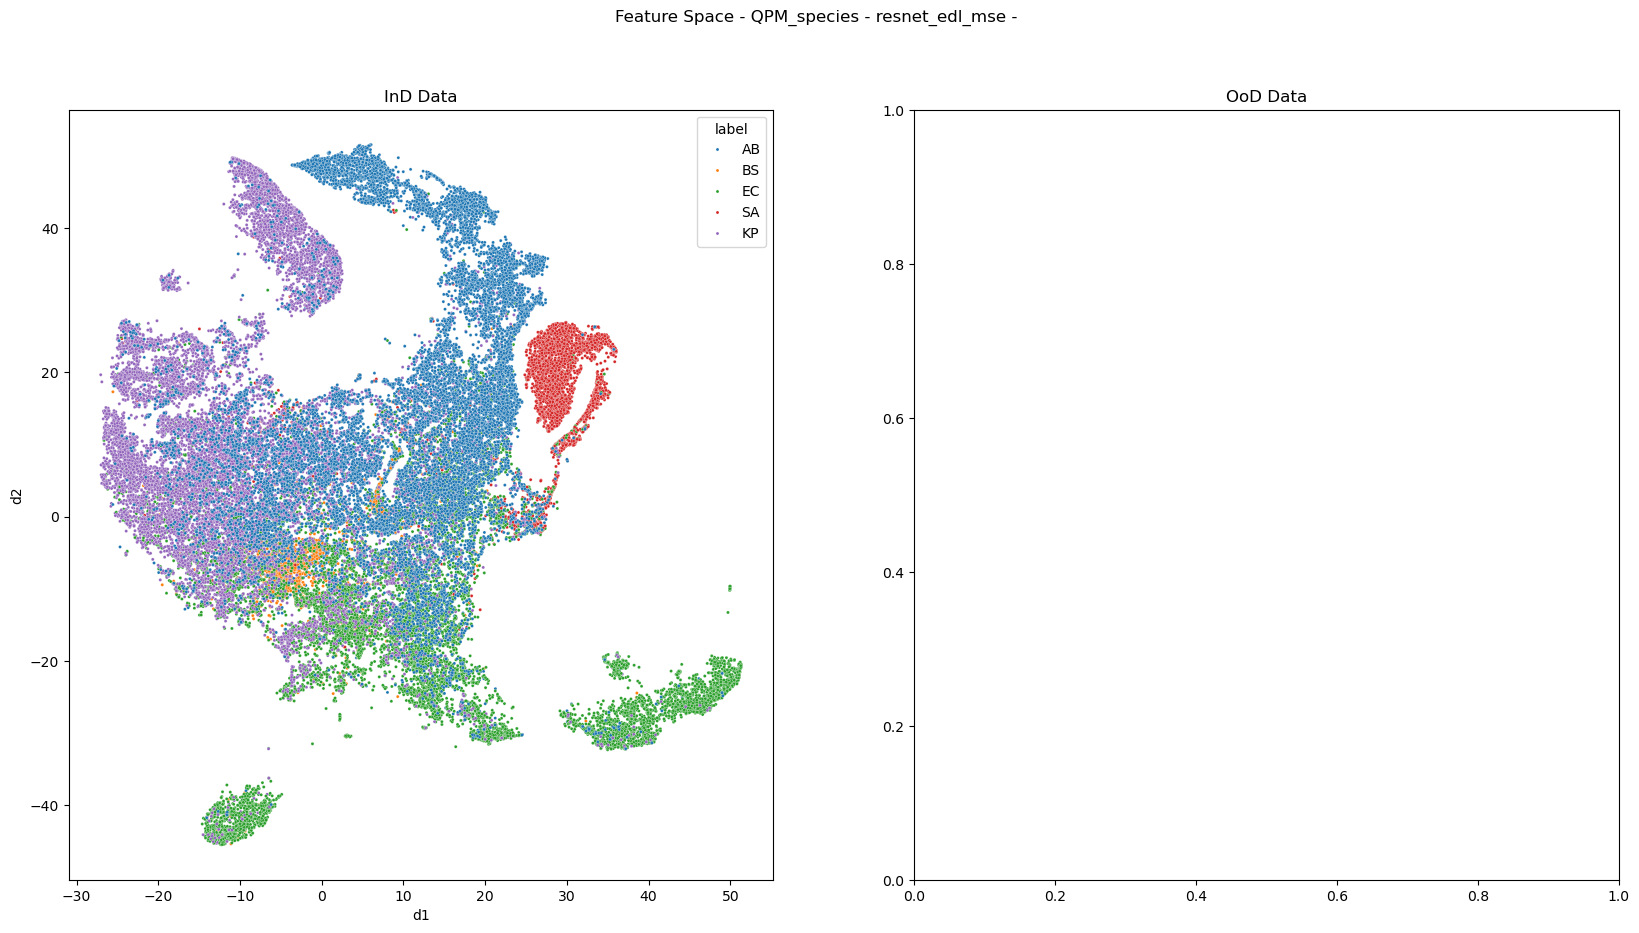

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

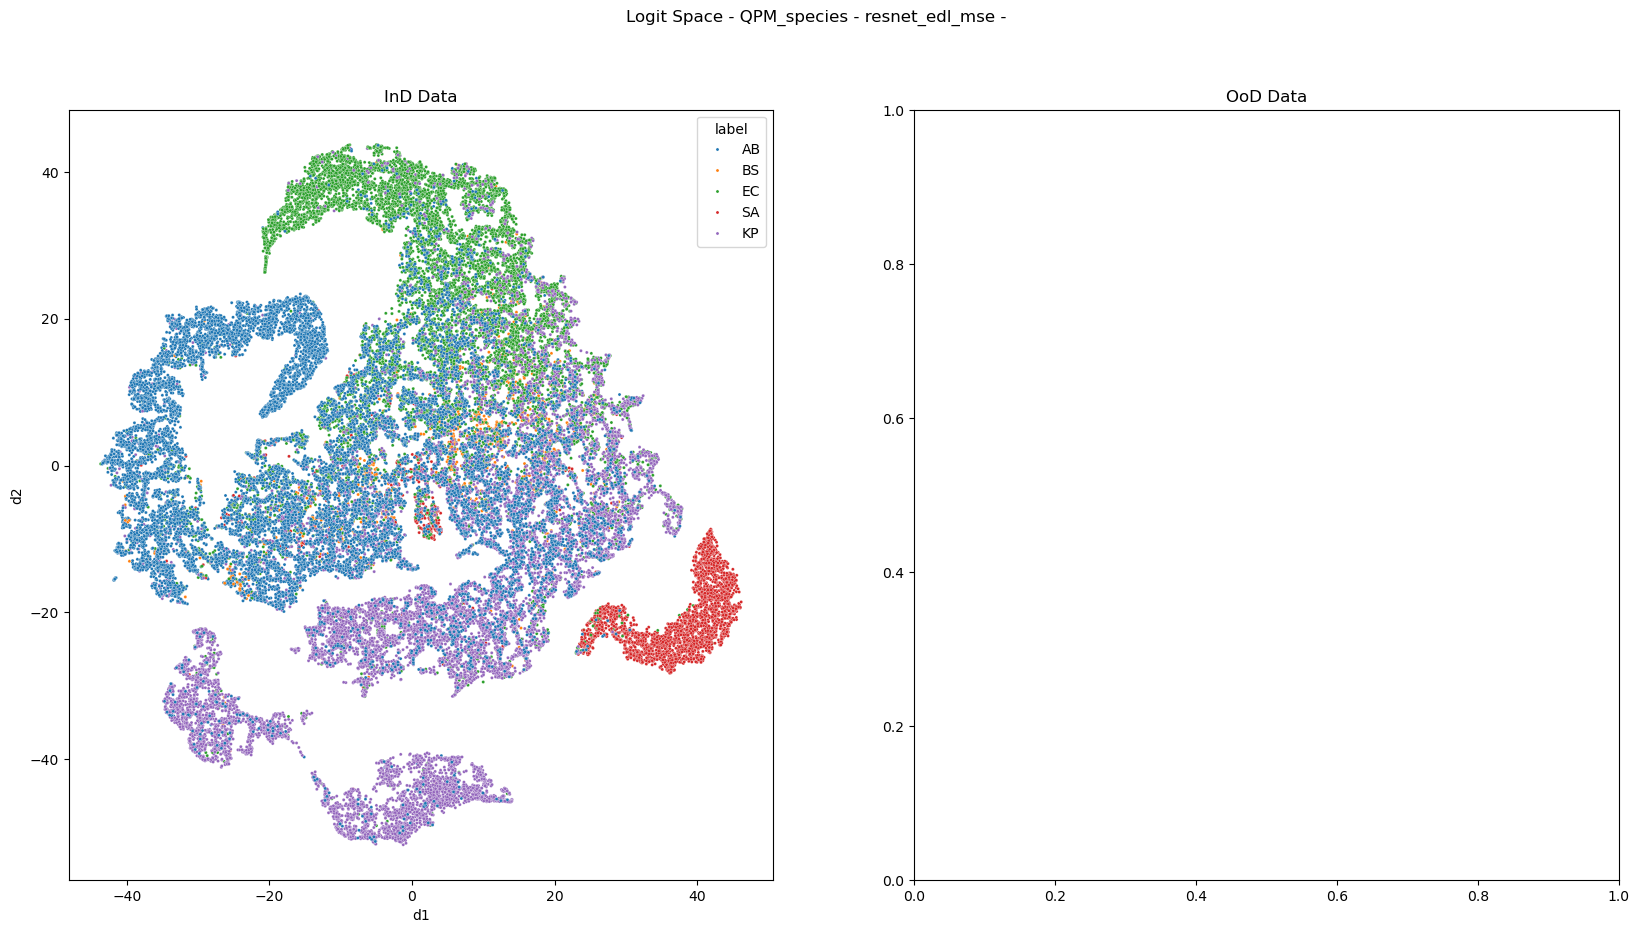

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:16<00:49, 16.51s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:33<00:33, 16.60s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:49<00:16, 16.66s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.84s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.75s/it]

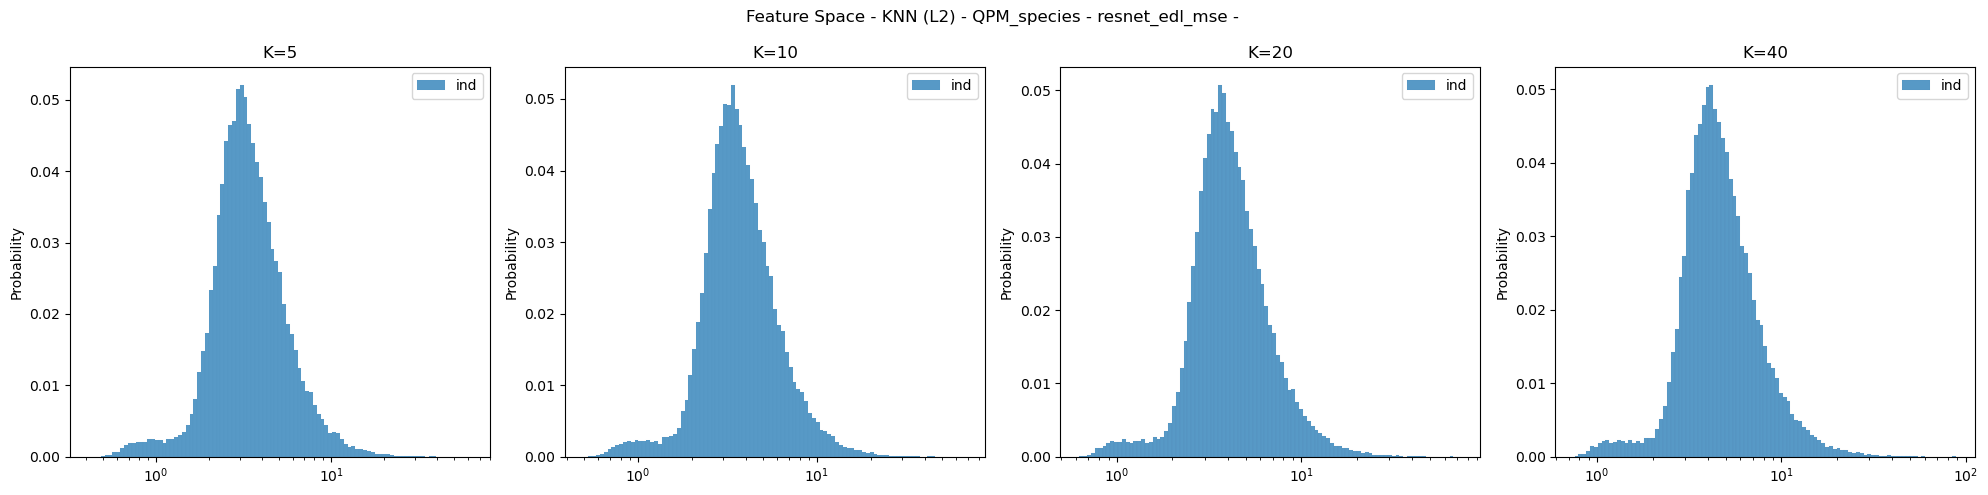

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:16<00:48, 16.15s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:32<00:32, 16.22s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:48<00:16, 16.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.53s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.43s/it]

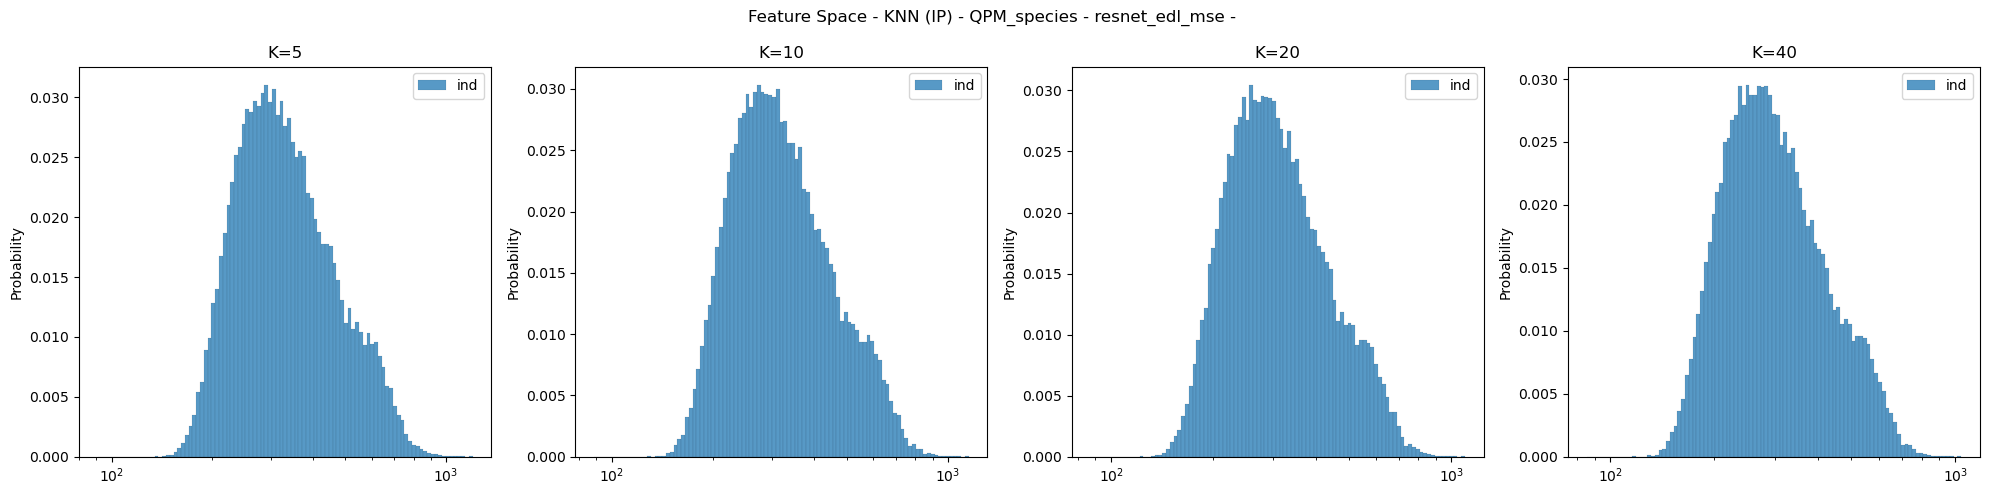

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:02<00:06,  2.27s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:04<00:04,  2.31s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:07<00:02,  2.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.57s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.49s/it]

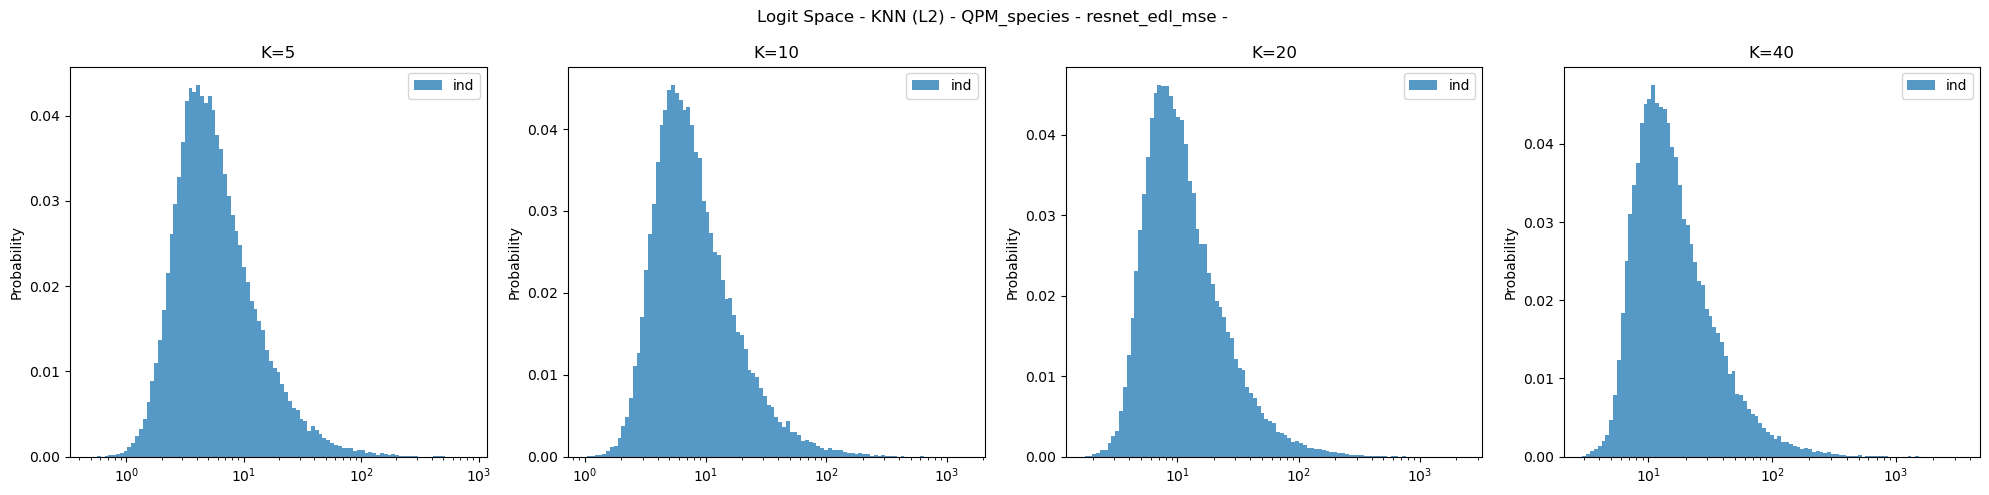

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:01<00:05,  1.96s/it]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:04<00:04,  2.02s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:06<00:02,  2.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.26s/it]

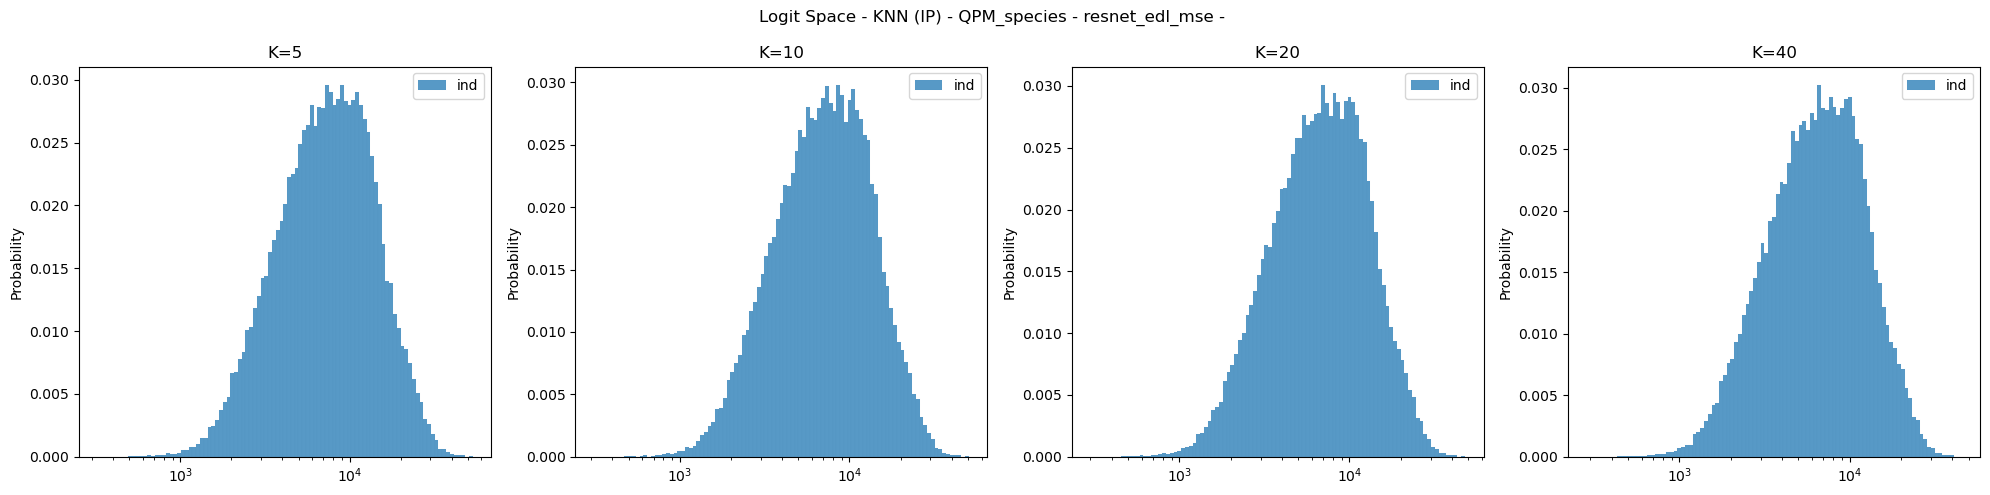

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

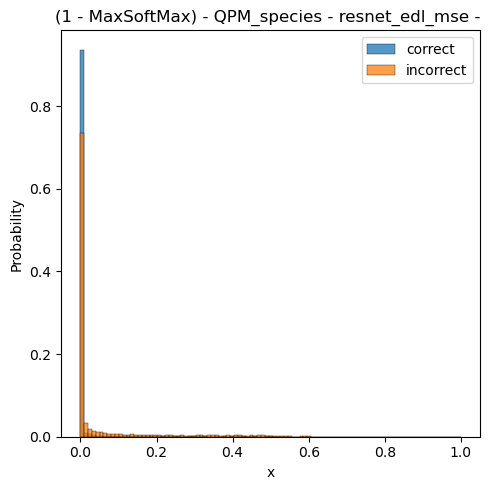

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

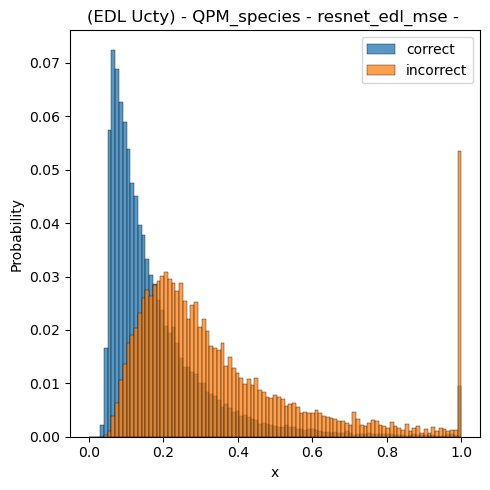

In [19]:
# plot (EDL uncertainty) distribution
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

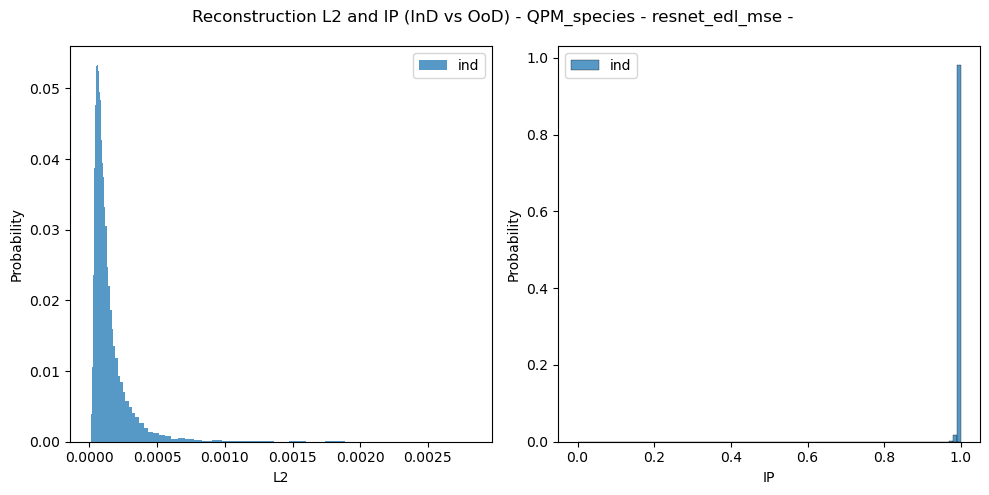

In [20]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()